In [1]:
!pip install astroquery astropy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.3 MB/s eta 0:00:00


In [17]:
%cd /content

/content


A1 complete — GAIA stars: 10


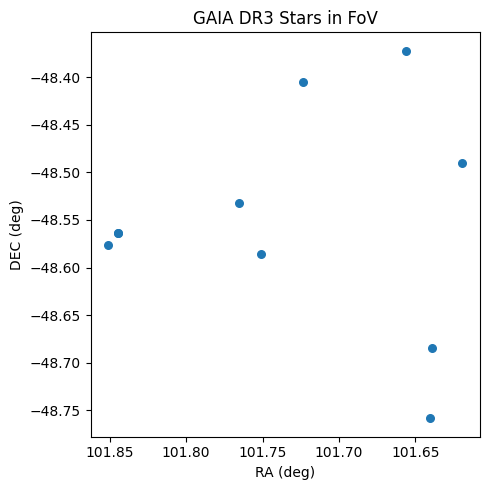

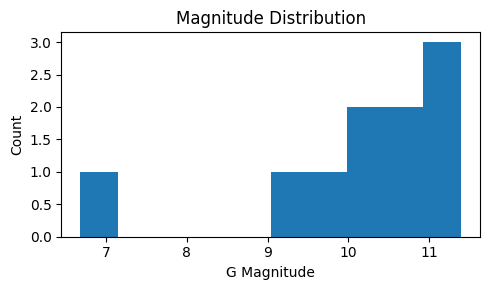

In [19]:
# A1
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
# ---- Metadata ----
RA0_DEG  = 101.812
DEC0_DEG = -48.565
FOV_X_DEG = 0.429
FOV_Y_DEG = 0.429
MAG_LIMIT = 11.5

query = f"""
SELECT ra, dec, phot_g_mean_mag
FROM gaiadr3.gaia_source
WHERE
  CONTAINS(
    POINT('ICRS', ra, dec),
    BOX('ICRS', {RA0_DEG}, {DEC0_DEG}, {FOV_X_DEG}, {FOV_Y_DEG})
  ) = 1
AND phot_g_mean_mag < {MAG_LIMIT}
ORDER BY phot_g_mean_mag ASC
"""

job = Gaia.launch_job(query)
gaia_df = job.get_results().to_pandas()

gaia_df.to_csv("data/gaia_catalog_star_centroids_2.csv", index=False)
print("A1 complete — GAIA stars:", len(gaia_df))

#------Catalog plots------
plt.figure(figsize=(5,5))
plt.scatter(gaia_df["ra"], gaia_df["dec"], s=30)
plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.title("GAIA DR3 Stars in FoV")
plt.gca().invert_xaxis()
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,3))
plt.hist(gaia_df["phot_g_mean_mag"], bins=10)
plt.xlabel("G Magnitude")
plt.ylabel("Count")
plt.title("Magnitude Distribution")
plt.tight_layout()
plt.show()

In [20]:
# A2: Catalog Feature Creation

import numpy as np
import pandas as pd

# ------------------------------------------------------------------
# Load Gaia catalog (RA, DEC in degrees)
# ------------------------------------------------------------------
gaia_df = pd.read_csv("data/gaia_catalog_star_centroids_2.csv")

ra = np.deg2rad(gaia_df["ra"].values)
dec = np.deg2rad(gaia_df["dec"].values)

# ------------------------------------------------------------------
# Convert (RA, DEC) → unit vectors in Cartesian coordinates
# ------------------------------------------------------------------
vec_cat = np.vstack([
    np.cos(dec) * np.cos(ra),
    np.cos(dec) * np.sin(ra),
    np.sin(dec)
]).T

# ------------------------------------------------------------------
# Compute angular separation matrix
# ------------------------------------------------------------------
ang_cat = np.arccos(np.clip(vec_cat @ vec_cat.T, -1.0, 1.0))

# ------------------------------------------------------------------
# Extract k-nearest angular features
# ------------------------------------------------------------------
def angular_features(ang_mat, k=3):
    feats, idxs = [], []
    for i in range(len(ang_mat)):
        d = np.sort(ang_mat[i][ang_mat[i] > 0])  # exclude self-angle
        if len(d) >= k:
            feats.append(d[:k])
            idxs.append(i)
    return np.array(feats), np.array(idxs)

feat_cat, cat_idx = angular_features(ang_cat, k=3)

# ------------------------------------------------------------------
# Save outputs (NumPy + CSV)
# ------------------------------------------------------------------
np.save("data/catalog_vectors.npy", vec_cat)
np.save("data/catalog_features.npy", feat_cat)
np.save("data/catalog_indices.npy", cat_idx)

# Save catalog features as CSV for inspection / portability
features_df = pd.DataFrame(
    feat_cat,
    columns=[f"theta_{i+1}" for i in range(feat_cat.shape[1])]
)
features_df["catalog_index"] = cat_idx

features_df.to_csv("data/catalog_features.csv", index=False)

print("A2 complete — catalog features shape:", feat_cat.shape)
print("Saved:")
print(" - data/catalog_vectors.npy")
print(" - data/catalog_features.npy")
print(" - data/catalog_indices.npy")
print(" - data/catalog_features.csv")

A2 complete — catalog features shape: (10, 3)
Saved:
 - data/catalog_vectors.npy
 - data/catalog_features.npy
 - data/catalog_indices.npy
 - data/catalog_features.csv


In [24]:
from google.colab import files
uploaded = files.upload()


Saving star_centroids_2.csv to star_centroids_2 (1).csv


A3 complete — initial matches: 2


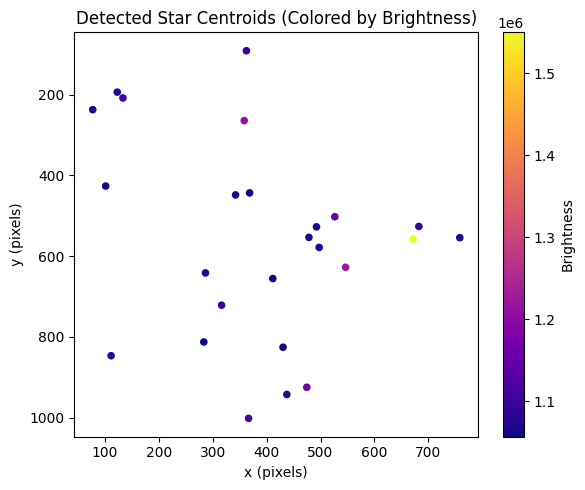

In [25]:
# A3: Image Feature Creation & Matching

import numpy as np
import pandas as pd
from scipy.spatial import KDTree

# ---- Load centroids ----
df = pd.read_csv("data/star_centroids_2.csv")
df = df.sort_values("brightness", ascending=False).iloc[:25].reset_index(drop=True)

# ---- Camera model ----
IMAGE_W, IMAGE_H = 1024, 1024
FOCAL_MM = 4912
PIXEL_UM = 3.6

cx, cy = IMAGE_W/2, IMAGE_H/2
f_pix = (FOCAL_MM * 1e3) / PIXEL_UM

dx = df["x_centroid"].values - cx
dy = df["y_centroid"].values - cy

vec_img = np.vstack([dx, dy, np.ones_like(dx)*f_pix]).T
vec_img /= np.linalg.norm(vec_img, axis=1)[:, None]

ang_img = np.arccos(np.clip(vec_img @ vec_img.T, -1, 1))

def angular_features(ang_mat, k=3):
    feats, idxs = [], []
    for i in range(len(ang_mat)):
        d = np.sort(ang_mat[i][ang_mat[i] > 0])
        if len(d) >= k:
            feats.append(d[:k])
            idxs.append(i)
    return np.array(feats), np.array(idxs)

feat_img, img_idx = angular_features(ang_img, k=3)

# ---- Load catalog features ----
feat_cat = np.load("data/catalog_features.npy")
cat_idx = np.load("data/catalog_indices.npy")

tree = KDTree(feat_cat)

used_catalog = set()
matches = []

for i, f in enumerate(feat_img):
    dist, j = tree.query(f, distance_upper_bound=0.03)
    if np.isfinite(dist) and j not in used_catalog:
        used_catalog.add(j)
        matches.append((img_idx[i], cat_idx[j]))

np.save("data/initial_matches.npy", matches)
np.save("data/image_vectors.npy", vec_img)

print("A3 complete — initial matches:", len(matches))
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))
sc = plt.scatter(
    df["x_centroid"],
    df["y_centroid"],
    c=df["brightness"],
    cmap="plasma",
    s=20
)
plt.gca().invert_yaxis()
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.title("Detected Star Centroids (Colored by Brightness)")
plt.colorbar(sc, label="Brightness")
plt.tight_layout()
plt.show()

A4 complete — RMS (arcsec): 7.3288620651283525


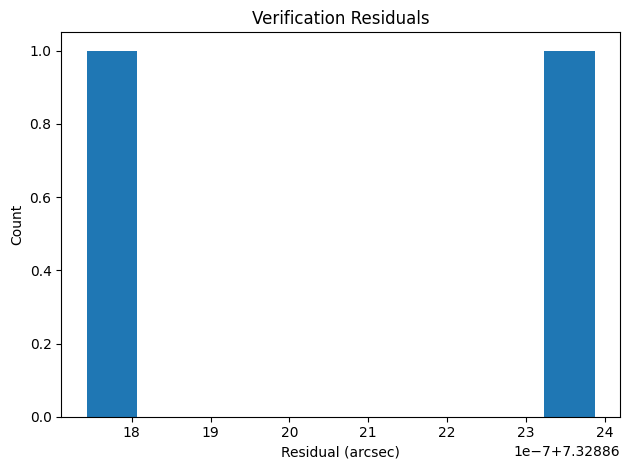

In [30]:
# A4: Verification & Orientation Estimation

import numpy as np

vec_img = np.load("data/image_vectors.npy")
vec_cat = np.load("data/catalog_vectors.npy")
matches = np.load("data/initial_matches.npy", allow_pickle=True)
img_indices = np.array([vec_img[m[0]] for m in matches])
cat_indices = np.array([vec_cat[m[1]] for m in matches])

def solve_rotation(A, B):
    H = B.T @ A
    U, _, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[-1] *= -1
        R = Vt.T @ U.T
    return R

R = solve_rotation(img_indices,cat_indices)
V_rot = (R @ V_cat.T).T

res = np.arccos(np.clip(np.sum(img_indices * V_rot, axis=1), -1, 1))
res_arcsec = res * 180/np.pi * 3600

inliers = res_arcsec < 300
np.save("data/inliers.npy", inliers)

print("A4 complete — RMS (arcsec):", np.sqrt(np.mean(res_arcsec[inliers]**2)))
import matplotlib.pyplot as plt
plt.hist(res_arcsec, bins=10)
plt.xlabel("Residual (arcsec)")
plt.ylabel("Count")
plt.title("Verification Residuals")
plt.tight_layout()
plt.show()

A5 complete — final CSV saved


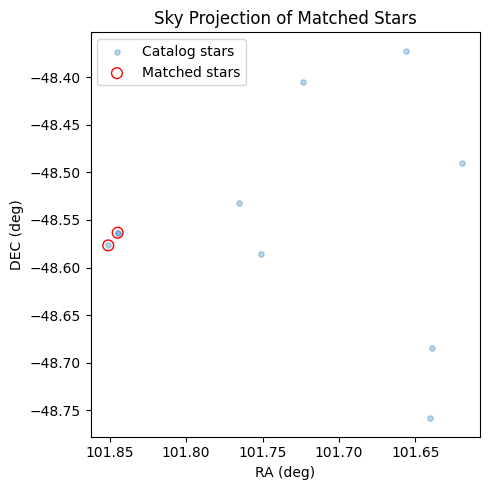

In [32]:
#A5
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("data/star_centroids_2.csv")
gaia_df = pd.read_csv("data/gaia_catalog_star_centroids_2.csv")

matches = np.load("data/initial_matches.npy", allow_pickle=True)
inliers = np.load("data/inliers.npy")

# Build rows safely
rows = []

for (img_i, cat_i), ok in zip(matches, inliers):
    if ok:
        rows.append({
            "x_centroid": df.loc[int(img_i), "x_centroid"],
            "y_centroid": df.loc[int(img_i), "y_centroid"],
            "brightness": df.loc[int(img_i), "brightness"],
            "ra": gaia_df.loc[int(cat_i), "ra"],
            "dec": gaia_df.loc[int(cat_i), "dec"],
            "magnitude": gaia_df.loc[int(cat_i), "phot_g_mean_mag"]
        })

matched_df = pd.DataFrame(rows)

matched_df
matched_df.to_csv(
    "data/matched_star_data_star_centroids_2.csv",
    index=False
)

print("A5 complete — final CSV saved")
plt.figure(figsize=(5,5))

plt.scatter(
    gaia_df["ra"],
    gaia_df["dec"],
    s=15,
    alpha=0.3,
    label="Catalog stars"
)

plt.scatter(
    matched_df["ra"],
    matched_df["dec"],
    s=60,
    facecolors="none",
    edgecolors="red",
    label="Matched stars"
)

plt.xlabel("RA (deg)")
plt.ylabel("DEC (deg)")
plt.title("Sky Projection of Matched Stars")
plt.gca().invert_xaxis()
plt.legend()
plt.tight_layout()
plt.show()
